In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [2]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
print(df_weekly_sum.head())

  Variant                   Date                         Location  Freq
0   Alpha  2019-12-30/2020-01-05  Africa / South Africa / Gauteng     1
1   Alpha  2019-12-30/2020-01-05            Asia / India / Kerala     5
2   Alpha  2019-12-30/2020-01-05        Asia / India / Tamil Nadu     1
3   Alpha  2019-12-30/2020-01-05                          Austria     4
4   Alpha  2019-12-30/2020-01-05                  Europe / Cyprus    21


In [3]:
# Assuming your dataset is stored in a DataFrame called 'df'
total_frequency = df_weekly_sum[df_weekly_sum['Location'] == 'USA']['Freq'].sum()

print("Total frequency of USA:", total_frequency)

Total frequency of USA: 2937839


In [4]:
# Assuming your dataset is stored in a DataFrame called 'df'
total_frequency = df_weekly_sum[df_weekly_sum['Location'] == 'Israel']['Freq'].sum()

print("Total frequency of Israel:", total_frequency)

Total frequency of Israel: 82517


In [5]:
import numpy as np

# Define the list of countries
countries = ['Austria', 'USA', 'Turkey', 'Israel', 'Italy', 'Spain', 'Ireland', 'France', 'Germany', 'Denmark', 'South Korea','Japan','Netherlands', 'Switzerland','Poland','Mexico','Brazil','Canada','Belgium']

# Create an empty dictionary to store the standard deviations
std_deviations = {}

# Iterate over the countries
for country in countries:
    # Filter the dataset for the current country
    country_data = df_weekly_sum[df_weekly_sum['Location'] == country]
    
    # Get the "Freq" column values for the current country
    country_freq = country_data['Freq']
    
    # Calculate the standard deviation
    std_dev = np.std(country_freq)
    mean = np.mean(country_freq)
    
    # Store the standard deviation in the dictionary
    std_deviations[country] = std_dev

# Print the standard deviations
for country, std_dev in std_deviations.items():
    print(f"Standard Deviation for {country}: {std_dev}")
    print(f"Mean for {country}: {mean}")


Standard Deviation for Austria: 645.5365056780948
Mean for Austria: 583.4202127659574
Standard Deviation for USA: 21661.07030634013
Mean for USA: 583.4202127659574
Standard Deviation for Turkey: 1912.2909996358385
Mean for Turkey: 583.4202127659574
Standard Deviation for Israel: 827.5635101737736
Mean for Israel: 583.4202127659574
Standard Deviation for Italy: 765.0818339027879
Mean for Italy: 583.4202127659574
Standard Deviation for Spain: 732.9918929366619
Mean for Spain: 583.4202127659574
Standard Deviation for Ireland: 1090.5126772279837
Mean for Ireland: 583.4202127659574
Standard Deviation for France: 2444.27326877043
Mean for France: 583.4202127659574
Standard Deviation for Germany: 4984.050284830088
Mean for Germany: 583.4202127659574
Standard Deviation for Denmark: 4305.376315944013
Mean for Denmark: 583.4202127659574
Standard Deviation for South Korea: 388.8276812226799
Mean for South Korea: 583.4202127659574
Standard Deviation for Japan: 2826.7835287827606
Mean for Japan: 58

In [6]:
# #check the standard deviation of the Freq column
# # Extract the 'Freq' column
# freq_column = df_weekly_sum['Freq']

# # Calculate the standard deviation
# std_dev = np.std(freq_column)

# print(f"Standard Deviation: {std_dev}")

In [7]:
# # Adding Gaussian noise to the last column
# mu = 0  # Mean of the Gaussian distribution
# sigma = 0.5  # Standard deviation of the Gaussian distribution

# # Add noise to the last column
# df_weekly_sum['Freq'] += np.random.normal(mu, sigma, len(df_weekly_sum))

# # Print the updated dataset
# print(df_weekly_sum.head())

In [8]:
# #function for choosing varianble std
# def variable_std(dataset, ratio):
#     # Adding Gaussian noise to the last column
#     mu = 0  # Mean of the Gaussian distribution
#     sigma = ratio  # Standard deviation of the Gaussian distribution

#     # Add noise to the last column
#     df_weekly_sum['Freq'] += np.random.normal(mu, sigma, len(df_weekly_sum))

#     # Print the updated dataset
# #     print(df_weekly_sum.head())
#     return df_weekly_sum.head()

# # df_weekly_sum = variable_std(df_weekly_sum, 0.5)
# # print(df_weekly_sum)
    

In [9]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
# def transform_ratio(clade_1, clade_2):
#     return np.log10(clade_1/clade_2)

def transform_ratio(clade_1, clade_2):
    clade_1 = np.where(clade_1 <= 0, np.nan, clade_1) #negative values are replaced with zeroes as the log of zero returns math error
    clade_2 = np.where(clade_2 <= 0, np.nan, clade_2)
    return clade_1 / clade_2

#     ratio = clade_1 / clade_2
#     with np.errstate(divide='ignore', invalid='ignore'):
#         result = np.log10(ratio)
#     return result


def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [10]:
def scatterplot(country, dataset, start, end, variant, mu): #, sigma = [0.1, 0.2, 0.5, 1, 1.5]):
    
    # Filter the dataset for the current country
    country_data = dataset[dataset['Location'] == country]
    
    # Get the "Freq" column values for the current country
    country_freq = country_data['Freq']
    
    # Calculate the standard deviation
    std_dev = np.std(country_freq)
    print(f"std_dev of {country}: {std_dev}")

    # Choose the appropriate sigma value based on the standard deviation
    if std_dev < 500:
        sigma = 0.1
    elif 500 <= std_dev < 10000:
        sigma = 0.2
    else:
        sigma = 1.5

    # Adding Gaussian noise to the last column
    mu = mu  # Mean of the Gaussian distribution
#     sigma = sigma  # Standard deviation of the Gaussian distribution

    # Add noise to the last column
    dataset['Freq'] += np.random.normal(mu, sigma, len(df_weekly_sum))
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])
#     print(df_weekly.head())
    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
#     print(tmp.head())
    tmp.columns = ['0','1','2','3']
#     print(tmp.head())

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
#     print(df_weekly.head())
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
#     df_sum.to_csv(r'df_sum.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
    #print(df_)
 

    #scatterplot of omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc = {'figure.figsize':(3,3)})
#     plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
    pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
    marker = ['.', '+', 'v', 'x','*']
    legend=[]
    c=0
    # Create a list to store the slope values and corresponding locations
    slope_values = []
    
#     for i in pango_compare:
#         if i != 'Omicron': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
#             mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['Omicron vs {0}'.format(i)][mask])
# #             print('test')
# #             print(slope)
# #             print(intercept)
#             slope_values.append((country, slope))  # Append tuple of location and slope value
#             print(f"Slope values: {slope_values}")
#             sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color = 'red')
#             # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
#         c+=1
      
    for i in pango_compare:
        if i != 'Omicron':
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
            if np.any(mask):
                slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
                slope_values.append((country, slope))
                print(f'Slope Values: {slope_values}')
                print(f'R-squared Values: {r_value ** 2}')
                print(f"p-value: {p_value:0.10f}")
                sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
            else:
                print(f"No data available for Omicron vs {i}")
        c += 1
    '''
    #Save the slope values of corresponding countries to a CSV file
    # Define the file path to save the CSV
    csv_file = 'Omicron_Vs_delta_slope_values_countries_with_noise.csv'

    # Append the slope values to the CSV file
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
        writer.writerows(slope_values)  # Append the slope values

    print('Slope values saved to', csv_file)
    '''
    
#     plt.legend(loc='upper left', prop={'size': 11}, facecolor='white', fontsize = 8) 
    plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
    plt.title(f'Omicron vs Delta\n(with Gaussian Noise)\nmean:{mu} std: {sigma}\n Time Window: ({start}) - ({end})\nLocation : {country}', fontsize=7.5)
    plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
    plt.rc('axes', labelsize=7.5)  # Adjust the label font size
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')  # Set plot background color to white
    

   
    # Add vertical bars for x-axis and y-axis without changing the range
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
 
    
    #Save the figures to `omicron_vs_delta_regression_plots` folder
    import os

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots_with_noise/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, country + "_regression_Omicron_vs_delta_with_noise.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.savefig(country+"_slope"+'.png')

std_dev of USA: 21661.07030634013
['2022-03', '2022-04', '2022-05']
Slope Values: [('USA', 35.671590291861456)]
R-squared Values: 0.9627097896175164
p-value: 0.0000000981


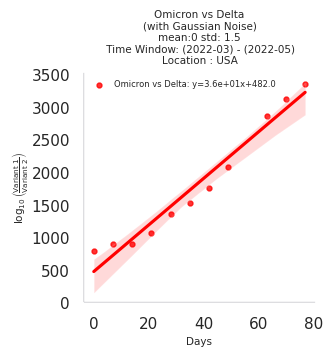

In [11]:
scatterplot('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variant = 'Delta', mu =0)  #you can pass a list of variants to compare

In [12]:
# scatterplot('USA', df_weekly_sum, start = '2022-03', end = '2022-05', variant = 'Delta', mu =0, sigma= 3)  #you can pass a list of variants to compare

std_dev of Turkey: 1912.4318584597988
['2021-11', '2021-12']
Slope Values: [('Turkey', 0.0031889018828275602)]
R-squared Values: 0.8429811856065482
p-value: 0.0818599314


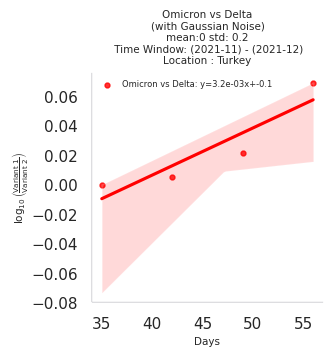

In [13]:
scatterplot('Turkey', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu = 0)

std_dev of Israel: 827.7743204309526
['2021-11', '2021-12']
Slope Values: [('Israel', 0.014018724164281064)]
R-squared Values: 0.8377707629358745
p-value: 0.0104577546


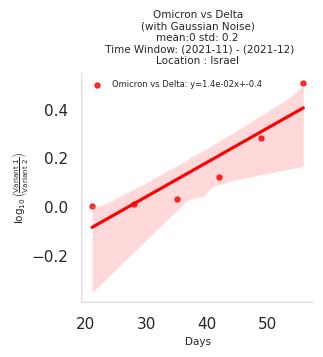

In [14]:
scatterplot('Israel', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Italy: 764.9449661130047
['2021-11', '2021-12']
Slope Values: [('Italy', 0.006130605411890702)]
R-squared Values: 0.7450740526765292
p-value: 0.0268002067


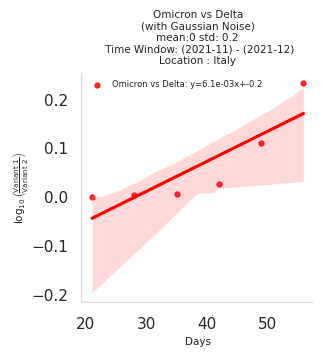

In [15]:
scatterplot('Italy', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Spain: 732.8584059662991
['2021-11', '2021-12']
Slope Values: [('Spain', 0.010228770402276342)]
R-squared Values: 0.9289212031143507
p-value: 0.0019413457


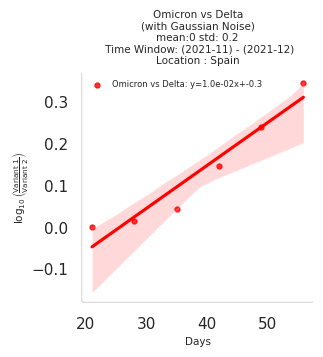

In [16]:
scatterplot('Spain', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Ireland: 1090.5390756044249
['2021-11', '2021-12']
Slope Values: [('Ireland', 0.009712731929684651)]
R-squared Values: 0.9209579363894715
p-value: 0.0024074943


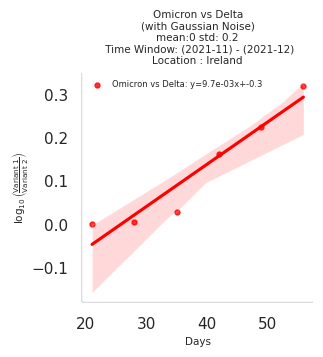

In [17]:
scatterplot('Ireland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of France: 2444.206857720731
['2021-11', '2021-12']
Slope Values: [('France', 0.004666442907801674)]
R-squared Values: 0.6571104835518075
p-value: 0.0146589756


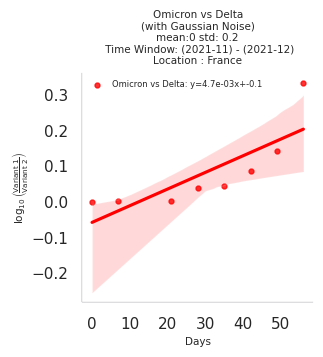

In [18]:
scatterplot('France', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Germany: 4984.134605040452
['2021-12', '2022-01']
Slope Values: [('Germany', 0.03170068206899273)]
R-squared Values: 0.9344134772140542
p-value: 0.0000215862


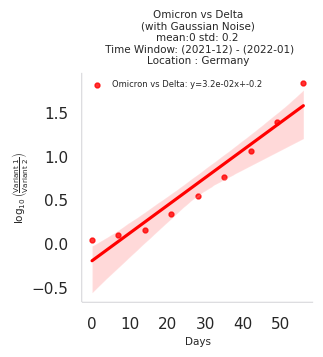

In [19]:
scatterplot('Germany', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta', mu =0)

std_dev of Denmark: 4305.333303809399
['2021-12', '2022-01']
Slope Values: [('Denmark', 0.08057520079159637)]
R-squared Values: 0.9601347467544548
p-value: 0.0000037399


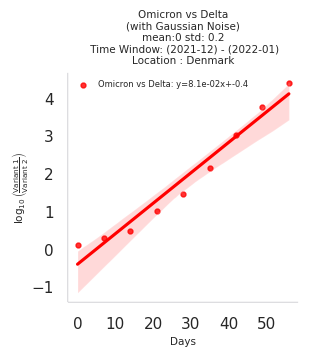

In [20]:
scatterplot('Denmark', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta', mu =0)

std_dev of South Korea: 388.8698580404509
['2021-11', '2021-12', '2022-01']
Slope Values: [('South Korea', 0.006105557777749465)]
R-squared Values: 0.8484599547709438
p-value: 0.0000567553


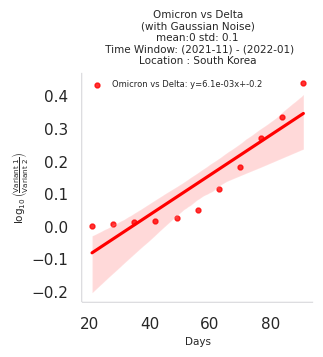

In [21]:
scatterplot('South Korea', df_weekly_sum, start = '2021-11', end = '2022-01', variant = 'Delta', mu =0)

std_dev of Japan: 2826.9102985241975
['2021-12', '2022-01']
Slope Values: [('Japan', 0.3081820592968824)]
R-squared Values: 0.9294049153212878
p-value: 0.0000279855


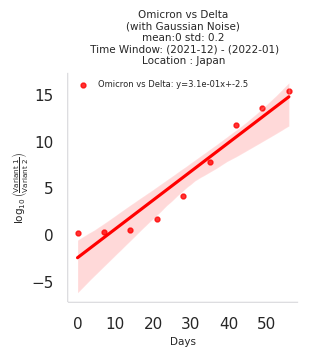

In [22]:
scatterplot('Japan', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta', mu =0)

std_dev of Netherlands: 748.9192293421418
['2021-11', '2021-12']
Slope Values: [('Netherlands', 0.0037539595253205413)]
R-squared Values: 0.8580906489590818
p-value: 0.0027182864


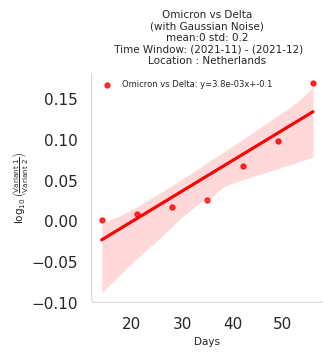

In [23]:
scatterplot('Netherlands', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Switzerland: 957.8322022830351
['2021-11', '2021-12']
Slope Values: [('Switzerland', 0.0039052837030858606)]
R-squared Values: 0.8131645553620472
p-value: 0.0055076478


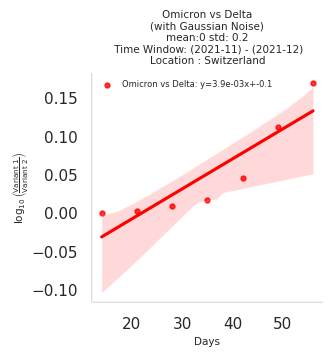

In [24]:
scatterplot('Switzerland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Poland: 993.118949330499
['2021-11', '2021-12']
Slope Values: [('Poland', 0.002323931731468423)]
R-squared Values: 0.7548483049618604
p-value: 0.1311799352


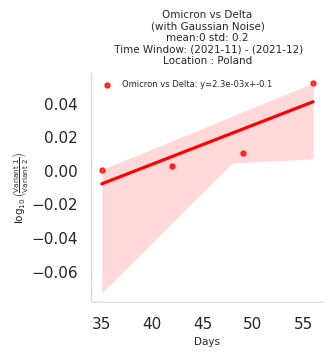

In [25]:
scatterplot('Poland', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Mexico: 427.07521050297777
['2021-11', '2021-12']
Slope Values: [('Mexico', 0.009535882203427801)]
R-squared Values: 0.6600331502729897
p-value: 0.0263814437


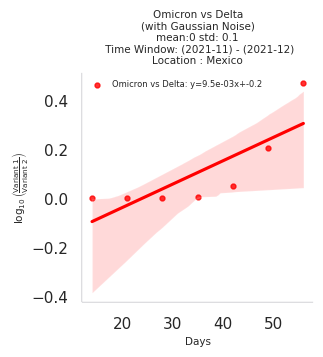

In [26]:
scatterplot('Mexico', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Brazil: 1088.9181734132733
['2021-11', '2021-12']
Slope Values: [('Brazil', 0.006347486915758774)]
R-squared Values: 0.6702697509985465
p-value: 0.0463248792


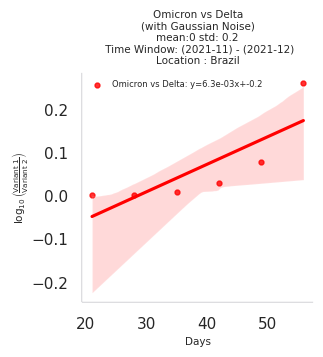

In [27]:
scatterplot('Brazil', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Canada: 2122.404932425802
['2021-11', '2021-12']
Slope Values: [('Canada', 0.009484864544572912)]
R-squared Values: 0.704185928642486
p-value: 0.0046773058


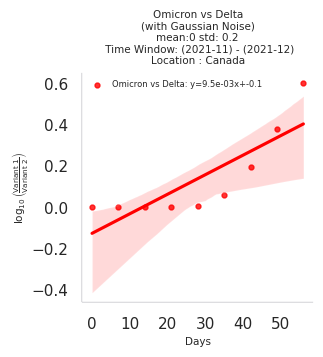

In [28]:
scatterplot('Canada', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu =0)

std_dev of Belgium: 753.6656635609199
['2021-12', '2022-01']
Slope Values: [('Belgium', 0.05173419247547257)]
R-squared Values: 0.9624637329802956
p-value: 0.0000030266


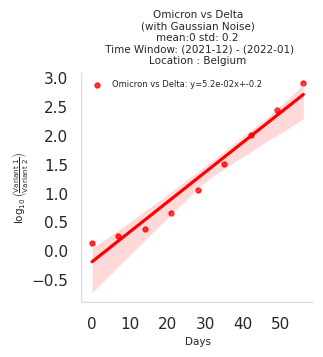

In [29]:
scatterplot('Belgium', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta', mu =0)

# `Bar Plot` of the slope values in diffeerent `Countries`

In [30]:
slope_values_of_countries = pd.read_csv('Omicron_Vs_delta_slope_values_countries_with_noise.csv')
print(slope_values_of_countries)

       Location     Slope
0           USA  0.006798
1        Turkey  0.069267
2        Israel  0.070956
3         Italy  0.063579
4         Spain  0.060152
5       Ireland  0.068930
6        France  0.048703
7       Germany  0.029113
8       Denmark  0.027644
9   South Korea  0.032945
10       France  0.048703
11        Japan  0.039702
12  Netherlands  0.041643
13  Switzerland  0.057268
14       Poland  0.069810
15       Mexico  0.058557
16       Brazil  0.060995
17       Canada  0.056904
18      Belgium  0.023763


In [31]:
slope_values_of_countries = slope_values_of_countries.drop_duplicates()
print(slope_values_of_countries.describe())
print("\n")

# Find the minimum and maximum slope values
min_slope_value = slope_values_of_countries['Slope'].min()
max_slope_value = slope_values_of_countries['Slope'].max()

# Find the corresponding countries for the minimum and maximum slope values
min_slope_countries = slope_values_of_countries[slope_values_of_countries['Slope'] == min_slope_value]['Location']
max_slope_countries = slope_values_of_countries[slope_values_of_countries['Slope'] == max_slope_value]['Location']

# Print the results
print(f"Min Slope Value: {min_slope_value}")
print(f"Country: {', '.join(min_slope_countries)}")
print("\n")
print(f"Max Slope Value: {max_slope_value}")
print(f"Country: {', '.join(max_slope_countries)}")
print("\n")
print(f"Average Slope Value: {slope_values_of_countries['Slope'].mean()}")


           Slope
count  18.000000
mean    0.049263
std     0.018931
min     0.006798
25%     0.034635
50%     0.057086
75%     0.062933
max     0.070956


Min Slope Value: 0.0067981351186434
Country: USA


Max Slope Value: 0.0709555013894883
Country: Israel


Average Slope Value: 0.049262807946802184


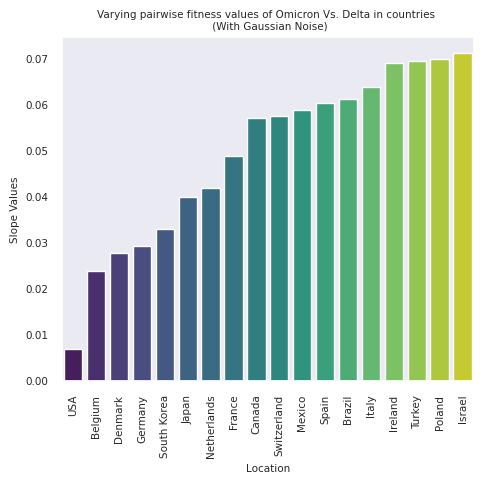

In [32]:
# Sort the DataFrame by 'Slope' column in ascending order
slope_values_of_countries = slope_values_of_countries.sort_values('Slope', ascending=True)

# Define the color palette
color_palette = sns.color_palette('viridis', len(slope_values_of_countries))

# Plot the bar plot with the specified color palette
plt.figure(figsize=(5, 5))
sns.barplot(x='Location', y='Slope', data=slope_values_of_countries, palette=color_palette)
plt.xlabel('Location', fontsize = 7.5)
plt.ylabel('Slope Values', fontsize = 7.5)
plt.title('Varying pairwise fitness values of Omicron Vs. Delta in countries \n (With Gaussian Noise)', fontsize = 7.5)
plt.xticks(rotation=90)
plt.grid(False)  # Turn off the grid lines
plt.tight_layout()

# Specify the directory path
directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots_with_noise/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the figure to the specified directory with DPI set to 300
filename = os.path.join(directory, "countries_bar_plot_Omicron_vs_delta.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

# Display the figure
plt.show()


# % change in R2 after adding noise

In [3]:
import pandas as pd

# Data before adding noise
data_before = {
    "Country": ["USA", "Canada", "Brazil", "Germany", "Belgium", "Italy", "Turkey", "Israel", "Ireland", "Spain", "France", "Denmark", "South Korea", "Japan", "Netherlands", "Switzerland", "Poland", "Mexico"],
    "R2_before": [0.99, 0.94, 0.98, 0.96, 0.97, 0.98, 0.97, 0.97, 0.93, 0.91, 0.91, 0.94, 0.90, 0.94, 0.898, 0.91, 0.99, 0.96],
    "Time_Window": ['2022-03 - 2022-05', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-12 - 2022-01', '2021-12 - 2022-01', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-12 - 2022-01', '2021-11 - 2022-01', '2021-12 - 2022-01', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12']
}

# Data after adding noise
data_after = {
    "Country": ["USA", "Canada", "Brazil", "Germany", "Belgium", "Italy", "Turkey", "Israel", "Ireland", "Spain", "France", "Denmark", "South Korea", "Japan", "Netherlands", "Switzerland", "Poland", "Mexico"],
    "R2_after": [0.95, 0.70, 0.67, 0.93, 0.96, 0.75, 0.75, 0.84, 0.92, 0.93, 0.66, 0.96, 0.85, 0.93, 0.82, 0.81, 0.76, 0.65],
    "Comparison": ["Omicron Vs. Delta"] * 18,
    "Slope_Value": [33.49, 0.009, 0.006, 0.031, 0.051, 0.006, 0.002, 0.014, 0.009, 0.010, 0.005, 0.081, 0.006, 0.31, 0.003, 0.004, 0.002, 0.009],
    "Time_Window": ['2022-03 - 2022-05', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-12 - 2022-01', '2021-12 - 2022-01', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-12 - 2022-01', '2021-11 - 2022-01', '2021-12 - 2022-01', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12', '2021-11 - 2021-12']
}

# Create DataFrames
df_before = pd.DataFrame(data_before)
df_after = pd.DataFrame(data_after)

# Merge the data
df = pd.merge(df_before, df_after, on="Country")

# Calculate percentage change
df['Percentage_Change'] = ((df['R2_after'] - df['R2_before']) / df['R2_before']) * 100

# Calculate the average percentage change
average_percentage_change = df['Percentage_Change'].mean()

# Calculate the average R2 value after adding noise
average_r2_before = df['R2_before'].mean()

# Calculate the average R2 value after adding noise
average_r2_after = df['R2_after'].mean()

# Print percentage change for individual countries
print(df[['Country', 'R2_before', 'R2_after', 'Percentage_Change']])

# Print the average percentage change
print(f'Average Percentage Change: {average_percentage_change:.2f}%')

# Print the average R2 value after adding noise
print(f'Average R2 Value Before Adding Noise: {average_r2_before:.2f}')

# Print the average R2 value after adding noise
print(f'Average R2 Value After Adding Noise: {average_r2_after:.2f}')


        Country  R2_before  R2_after  Percentage_Change
0           USA      0.990      0.95          -4.040404
1        Canada      0.940      0.70         -25.531915
2        Brazil      0.980      0.67         -31.632653
3       Germany      0.960      0.93          -3.125000
4       Belgium      0.970      0.96          -1.030928
5         Italy      0.980      0.75         -23.469388
6        Turkey      0.970      0.75         -22.680412
7        Israel      0.970      0.84         -13.402062
8       Ireland      0.930      0.92          -1.075269
9         Spain      0.910      0.93           2.197802
10       France      0.910      0.66         -27.472527
11      Denmark      0.940      0.96           2.127660
12  South Korea      0.900      0.85          -5.555556
13        Japan      0.940      0.93          -1.063830
14  Netherlands      0.898      0.82          -8.685969
15  Switzerland      0.910      0.81         -10.989011
16       Poland      0.990      0.76         -23